In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
import requests
import json
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/covid19countryinfo.csv
./input/SIR_data.csv
./input/states-daily.csv
./input/covid19-deepscore.csv
./input/population_data.csv
./input/full-list-total-tests-for-covid-19.csv
./input/country_codes.csv
./input/enriched_covid_19_week_2.csv
./input/covid19-global-forecasting-week-3/test.csv
./input/covid19-global-forecasting-week-3/submission.csv
./input/covid19-global-forecasting-week-3/train.csv
./input/korea/SeoulFloating.csv
./input/korea/TimeAge.csv
./input/korea/SearchTrend.csv
./input/korea/TimeProvince.csv
./input/korea/Weather.csv
./input/korea/PatientRoute.csv
./input/korea/PatientInfo.csv
./input/korea/Region.csv
./input/korea/TimeGender.csv
./input/korea/Case.csv
./input/korea/Time.csv
./input/covid19-global-forecasting-week-2/test.csv
./input/covid19-global-forecasting-week-2/submission.csv
./input/covid19-global-forecasting-week-2/train.csv
./input/covidAPI/ESP.json
./input/covidAPI/ICL.json
./input/covidAPI/CHN.json
./input/covidAPI/FRA.json
./input/covidAPI/THA.json

In [2]:
train_df = pd.read_csv("./input/SIR_data.csv")
train_df.tail()

,Unnamed: 0,Code,Date,confirmed,confirmed_noise,infectious_noise_rate,infectious_rate,removed,removed_noise,removed_noise_rate,removed_rate,susceptible,susceptible_noise,susceptible_noise_rate,susceptible_rate
119995,155,SIR-large-249,2020-07-05,6.813406e-09,8.345405e-09,4.172703e-14,3.406703e-14,1744.099053,1744.099053,0.00872,0.00872,198255.900947,198255.900947,0.99128,0.99128
119996,156,SIR-large-249,2020-07-06,3.576303e-09,3.202185e-09,1.601093e-14,1.788151e-14,1744.099053,1744.099053,0.00872,0.00872,198255.900947,198255.900947,0.99128,0.99128
119997,157,SIR-large-249,2020-07-07,1.854928e-09,1.278237e-09,6.391185e-15,9.274641e-15,1744.099053,1744.099053,0.00872,0.00872,198255.900947,198255.900947,0.99128,0.99128
119998,158,SIR-large-249,2020-07-08,9.504876e-10,1.032974e-09,5.164868e-15,4.752438e-15,1744.099053,1744.099053,0.00872,0.00872,198255.900947,198255.900947,0.99128,0.99128
119999,159,SIR-large-249,2020-07-09,4.810533e-10,6.917720e-10,3.458860e-15,2.405266e-15,1744.099053,1744.099053,0.00872,0.00872,198255.900947,198255.900947,0.99128,0.99128


In [3]:
days_in_sequence = 21
output_days = 7

sequence_length = days_in_sequence - 1
training_percentage = 0.9
temp_dim = 1

In [4]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,temp_dim))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

# removed output branch
rnn_f = layers.LSTM(32)(main_rnn_layer)
dense_f = layers.Dense(16)(rnn_f)
dropout_f = layers.Dropout(0.2)(dense_f)
output_f = layers.Dense(7)(dropout_f)
removed = layers.LeakyReLU(alpha=0.1, name="removed")(output_f)

model = Model([temporal_input_layer], [removed])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 20, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 119       
_________________________________________________________________
removed (LeakyReLU)          (None, 7)                 0         
Total para

In [5]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.6), #patience=4  #EarlyStopping(monitor='val_loss', patience=20)
             ModelCheckpoint(filepath='best_removed_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.mean_squared_logarithmic_error], optimizer="adam")

In [6]:
trend_list = []

for i in range(250):
    code = "SIR-small-{}".format(i)
    country_df = train_df.query(f"Code=='{code}'")
    # Added a quick hack to double the number of sequences
    # Warning: This will later create a minor leakage from the training set into the validation set.
    for i in range(0,len(country_df),int(days_in_sequence/2)):
        if i+days_in_sequence<=len(country_df):
            
            #prepare rate inputs, use rates with noise
            removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_rate]

            #prepare outputs, use original rates
            expected_removed_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].removed_rate]

            trend_list.append({ "removed_rate_trend":removed_rate_trend,
                                "expected_removed_rate":expected_removed_rate})
trend_df = pd.DataFrame(trend_list)

trend_df["temporal_inputs"] = [np.asarray([trends["removed_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_removed_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_removed_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

In [8]:
history = model.fit([X_temporal_train], [Y_removed_train], 
          epochs = 50, 
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_removed_test]), 
          callbacks=callbacks)
loss = history.history['loss']
val_loss = history.history['val_loss']

Train on 3150 samples, validate on 350 samples
Epoch 1/50
3150/3150 [==============================] - 12s 4ms/step - loss: 0.0012 - val_loss: 6.9939e-04
Epoch 2/50
3150/3150 [==============================] - 11s 3ms/step - loss: 8.5380e-04 - val_loss: 7.3895e-04
Epoch 3/50
3150/3150 [==============================] - 11s 3ms/step - loss: 8.0245e-04 - val_loss: 6.8807e-04
Epoch 4/50
3150/3150 [==============================] - 10s 3ms/step - loss: 7.5961e-04 - val_loss: 6.5706e-04
Epoch 5/50
3150/3150 [==============================] - 11s 4ms/step - loss: 7.5433e-04 - val_loss: 6.5417e-04
Epoch 6/50
3150/3150 [==============================] - 13s 4ms/step - loss: 7.4271e-04 - val_loss: 6.4871e-04
Epoch 7/50
3150/3150 [==============================] - 12s 4ms/step - loss: 7.2461e-04 - val_loss: 6.8767e-04
Epoch 8/50
3150/3150 [==============================] - 10s 3ms/step - loss: 7.2280e-04 - val_loss: 6.7216e-04
Epoch 9/50
3150/3150 [==============================] - 10s 3ms/step 

In [9]:
trend_list = []

for i in range(250):
    code = "SIR-small-{}".format(i)
    country_df = train_df.query(f"Code=='{code}'")
    # Added a quick hack to double the number of sequences
    # Warning: This will later create a minor leakage from the training set into the validation set.
    for i in range(0,len(country_df),int(days_in_sequence/2)):
        if i+days_in_sequence<=len(country_df):
            
            #prepare rate inputs, use rates with noise
            removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_noise_rate]

            #prepare outputs, use original rates
            expected_removed_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].removed_rate]

            trend_list.append({ "removed_rate_trend":removed_rate_trend,
                                "expected_removed_rate":expected_removed_rate})
trend_df = pd.DataFrame(trend_list)

trend_df["temporal_inputs"] = [np.asarray([trends["removed_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_removed_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_removed_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

In [10]:
history = model.fit([X_temporal_train], [Y_removed_train], 
          initial_epoch=50,
          epochs = 100,  
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_removed_test]), 
          callbacks=callbacks)
loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])

Train on 3150 samples, validate on 350 samples
Epoch 51/100
3150/3150 [==============================] - 9s 3ms/step - loss: 5.6160e-05 - val_loss: 7.5886e-06
Epoch 52/100
3150/3150 [==============================] - 9s 3ms/step - loss: 5.5330e-05 - val_loss: 6.1686e-06
Epoch 53/100
3150/3150 [==============================] - 9s 3ms/step - loss: 4.9486e-05 - val_loss: 7.9211e-06
Epoch 54/100
3150/3150 [==============================] - 9s 3ms/step - loss: 5.2226e-05 - val_loss: 6.4614e-06
Epoch 55/100
3150/3150 [==============================] - 9s 3ms/step - loss: 5.1572e-05 - val_loss: 6.9652e-06
Epoch 56/100
3150/3150 [==============================] - 9s 3ms/step - loss: 4.9676e-05 - val_loss: 5.5117e-06
Epoch 57/100
3150/3150 [==============================] - 9s 3ms/step - loss: 4.6895e-05 - val_loss: 7.8453e-06
Epoch 58/100
3150/3150 [==============================] - 9s 3ms/step - loss: 5.4497e-05 - val_loss: 7.1848e-06
Epoch 59/100
3150/3150 [==============================] -

In [11]:
trend_list = []

for i in range(250):
    code = "SIR-middle-{}".format(i)
    country_df = train_df.query(f"Code=='{code}'")
    # Added a quick hack to double the number of sequences
    # Warning: This will later create a minor leakage from the training set into the validation set.
    for i in range(0,len(country_df),int(days_in_sequence/2)):
        if i+days_in_sequence<=len(country_df):
            
            #prepare rate inputs, use rates with noise
            removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_noise_rate]

            #prepare outputs, use original rates
            expected_removed_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].removed_rate]

            trend_list.append({ "removed_rate_trend":removed_rate_trend,
                                "expected_removed_rate":expected_removed_rate})
trend_df = pd.DataFrame(trend_list)

trend_df["temporal_inputs"] = [np.asarray([trends["removed_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_removed_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_removed_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

In [12]:
history = model.fit([X_temporal_train], [Y_removed_train],
          initial_epoch=100,
          epochs = 150, 
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_removed_test]), 
          callbacks=callbacks)
loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])

Train on 3150 samples, validate on 350 samples
Epoch 101/150
3150/3150 [==============================] - 11s 3ms/step - loss: 2.7256e-05 - val_loss: 1.1719e-06
Epoch 102/150
3150/3150 [==============================] - 10s 3ms/step - loss: 2.6659e-05 - val_loss: 1.2253e-06
Epoch 103/150
3150/3150 [==============================] - 11s 3ms/step - loss: 2.3736e-05 - val_loss: 1.0932e-06
Epoch 104/150
3150/3150 [==============================] - 10s 3ms/step - loss: 2.5235e-05 - val_loss: 1.6390e-06
Epoch 105/150
3150/3150 [==============================] - 9s 3ms/step - loss: 2.4672e-05 - val_loss: 1.8008e-06
Epoch 106/150
3150/3150 [==============================] - 10s 3ms/step - loss: 2.5146e-05 - val_loss: 1.8904e-06
Epoch 107/150
3150/3150 [==============================] - 9s 3ms/step - loss: 2.9589e-05 - val_loss: 1.1097e-06
Epoch 108/150
3150/3150 [==============================] - 10s 3ms/step - loss: 2.5590e-05 - val_loss: 1.5870e-06
Epoch 109/150
3150/3150 [==================

In [13]:
trend_list = []

for i in range(250):
    code = "SIR-large-{}".format(i)
    country_df = train_df.query(f"Code=='{code}'")
    # Added a quick hack to double the number of sequences
    # Warning: This will later create a minor leakage from the training set into the validation set.
    for i in range(0,len(country_df),int(days_in_sequence/2)):
        if i+days_in_sequence<=len(country_df):
            
            #prepare rate inputs, use rates with noise
            removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_noise_rate]

            #prepare outputs, use original rates
            expected_removed_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].removed_rate]

            trend_list.append({ "removed_rate_trend":removed_rate_trend,
                                "expected_removed_rate":expected_removed_rate})
trend_df = pd.DataFrame(trend_list)

trend_df["temporal_inputs"] = [np.asarray([trends["removed_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_removed_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_removed_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

In [14]:
history = model.fit([X_temporal_train], [Y_removed_train],
          initial_epoch=150,
          epochs = 200, 
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_removed_test]), 
          callbacks=callbacks)
loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])

Train on 3150 samples, validate on 350 samples
Epoch 151/200
3150/3150 [==============================] - 9s 3ms/step - loss: 3.4886e-05 - val_loss: 4.5472e-06
Epoch 152/200
3150/3150 [==============================] - 9s 3ms/step - loss: 3.6625e-05 - val_loss: 3.9831e-06
Epoch 153/200
3150/3150 [==============================] - 9s 3ms/step - loss: 3.3289e-05 - val_loss: 4.0344e-06
Epoch 154/200
3150/3150 [==============================] - 9s 3ms/step - loss: 3.4813e-05 - val_loss: 3.8949e-06
Epoch 155/200
3150/3150 [==============================] - 9s 3ms/step - loss: 3.8915e-05 - val_loss: 3.8646e-06
Epoch 156/200
3150/3150 [==============================] - 9s 3ms/step - loss: 3.5542e-05 - val_loss: 3.9793e-06
Epoch 157/200
3150/3150 [==============================] - 9s 3ms/step - loss: 3.5643e-05 - val_loss: 3.8719e-06
Epoch 158/200
3150/3150 [==============================] - 9s 3ms/step - loss: 3.9677e-05 - val_loss: 3.7866e-06
Epoch 159/200
3150/3150 [========================

# 4. Performance during training

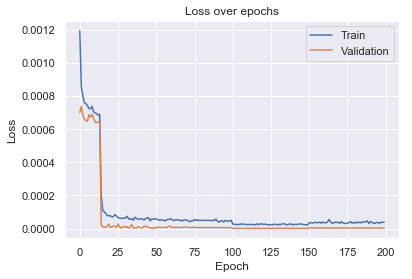

In [15]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# 5. Generate predictions using the model

In [17]:
model.load_weights("best_removed_model.h5")
predictions = model.predict([X_temporal_test])

In [19]:
display_limit = 30
for inputs, pred_removed, exp_removed in zip(X_temporal_test, predictions[:display_limit], Y_removed_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected removed rate:", exp_removed)
    print("Prediction:", pred_removed)

[[0.08901121]
 [0.08904027]
 [0.08906324]
 [0.08908131]
 [0.08909543]
 [0.0891064 ]
 [0.08911486]
 [0.08912136]
 [0.08912632]
 [0.08913007]
 [0.0891329 ]
 [0.08913501]
 [0.08913658]
 [0.08913773]
 [0.08913856]
 [0.08913917]
 [0.08913961]
 [0.08913992]
 [0.08914014]
 [0.0891403 ]]
Expected removed rate: [0.08914041 0.08914048 0.08914053 0.08914057 0.08914059 0.08914061
 0.08914062]
Prediction: [0.08868365 0.08894974 0.08911716 0.08939055 0.0899293  0.08971497
 0.08993942]
[[0.01395797]
 [0.01461757]
 [0.01525965]
 [0.01588254]
 [0.01648476]
 [0.01706497]
 [0.017622  ]
 [0.01815488]
 [0.01866283]
 [0.01914525]
 [0.01960174]
 [0.02003207]
 [0.02043051]
 [0.02079801]
 [0.02113563]
 [0.02144456]
 [0.02172612]
 [0.02198168]
 [0.02221268]
 [0.02242061]]
Expected removed rate: [0.02260698 0.02277331 0.0229196  0.02304769 0.02315934 0.02325622
 0.02333989]
Prediction: [0.02254074 0.02285709 0.02321348 0.02353872 0.02378734 0.02406138
 0.02434178]
[[0.00014045]
 [0.00017523]
 [0.00021612]
 [0.00